# Evaluation on Kang Data

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

# Do not show FutureWarnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import sys
import os
import pandas as pd
import numpy as np
import benchmark as bm
import plotnine as p9
from prismo import PRISMO
from prismo.pl import plot_weights, plot_factor_correlation
import seaborn as sns
import plotnine as p9
import matplotlib.pyplot as plt
import scanpy as sc

sys.path.append("..")
from plotting_settings import discrete_scale_fill, discrete_scale_color

%matplotlib
%matplotlib inline

# Settings
device = "cuda:1"
seed = 3141
rng = np.random.default_rng(seed)

/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


Spectra GPU support is still under development. Raise any issues on github 
 
 Changes from v1: 
 (1) GPU support [see tutorial] 
 (2) minibatching for local parameters and data 
 Note that minibatching may affect optimization results 
 Code will eventually be merged into spectra.py
Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Using matplotlib backend: module://matplotlib_inline.backend_inline


## Load data and Reactome pathways

In [2]:
# Train Parameters
FPR = 0.0
database = "RH"
version = "v1-3000"

adata, true_mask, noisy_mask, terms, true_mask_copy = bm.get_data(
    FPR, FPR, database=database, version=version, seed=seed, rng=rng
)
data_dict = bm.preprocess(adata)

print(adata.X.shape, true_mask.shape)

INFO:prismo._core.feature_sets:Found 16 pairs to merge.
INFO:prismo._core.feature_sets:Found 3 pairs to merge.
INFO:prismo._core.feature_sets:Found 2 pairs to merge.
INFO:prismo._core.feature_sets:Found 0 pairs to merge. Stopping...


<FeatureSets 'h.all.v7.5.1.symbols.gmt' with 13 feature sets>
<FeatureSets 'c2.cp.reactome.v7.5.1.symbols.gmt' with 73 feature sets>
<FeatureSets 'h.all.v7.5.1.symbols.gmt|c2.cp.reactome.v7.5.1.symbols.gmt' with 65 feature sets>
(13576, 3000) (65, 3000)


### Train PRISMO

In [3]:
for model_name_parmams in [
    f"prismo_0.003_200_5000_0.005_2_0.1_{database}_{FPR}_{version}_{database}_{seed}"
]:
    for model_name in ["prismo"]:

        def extract_params_from_string(s):
            if "nmf" in s:
                s = s.replace("_nmf", "")
            (
                lr,
                early_stopper_patience,
                max_epochs,
                prior_penalty,
                n_factors,
                dense_factor_scale,
                *rest,
            ) = s.split("_")[1:]
            return (
                lr,
                early_stopper_patience,
                max_epochs,
                prior_penalty,
                n_factors,
                dense_factor_scale,
            )

        (
            lr,
            early_stopper_patience,
            max_epochs,
            prior_penalty,
            n_factors,
            dense_factor_scale,
        ) = extract_params_from_string(model_name_parmams)

        print(
            f"Training with params: {lr}, {early_stopper_patience}, {max_epochs}, {prior_penalty}, {n_factors}, {dense_factor_scale}"
        )

        if os.path.exists(f"./models/{model_name_parmams}.h5"):
            print(f"Loading Model {model_name_parmams}")
            model = PRISMO.load(f"./models/{model_name_parmams}.h5")
        else:
            print("Training Model")
            model = bm.train_prismo(
                data_dict[model_name],
                noisy_mask,
                obs=adata.obs,
                var=adata.var,
                seed=seed,
                terms=terms,
                obs_names=adata.obs_names.copy(),
                var_names=adata.var_names.copy(),
                n_factors=n_factors,
                nmf="nmf" in model_name,
                prior_penalty=prior_penalty,
                max_epochs=max_epochs,
                batch_size=0,
                n_particles=1,
                lr=lr,
                early_stopper_patience=early_stopper_patience,
                device=device,
                true_mask=true_mask,
                init_factors="random",
                init_scale=0.1,
                save_path=f"./models/{model_name_parmams}.h5",
                dense_factor_scale=dense_factor_scale,
                # gamma_prior_scale=gamma_prior_scale,
            )

Training with params: 0.003, 200, 5000, 0.005, 2, 0.1
Loading Model prismo_0.003_200_5000_0.005_2_0.1_RH_0.0_v1-3000_RH_3141


<Axes: >

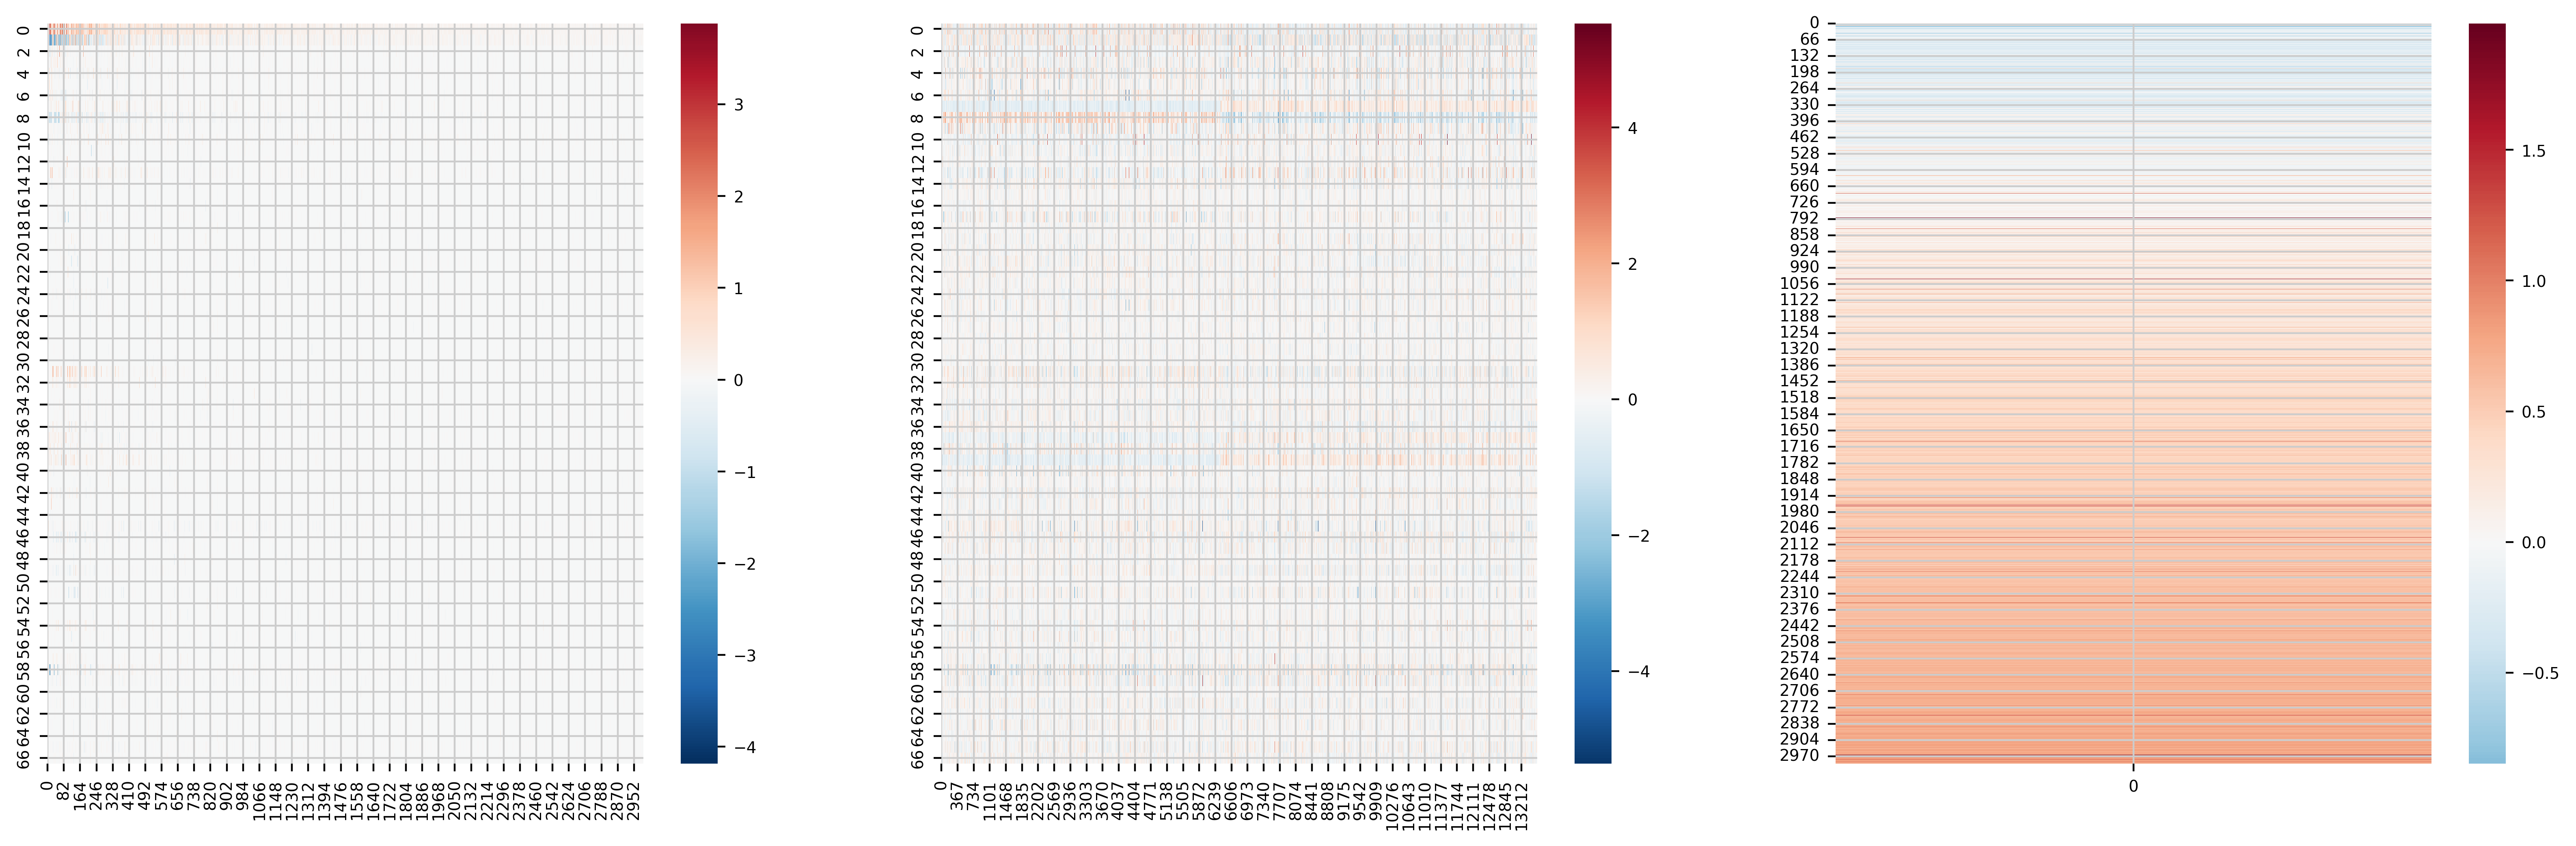

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
sns.heatmap(model.get_weights("numpy")["view_1"], ax=ax[0], cmap="RdBu_r", center=0)
sns.heatmap(model.get_factors("numpy")["group_1"].T, ax=ax[1], cmap="RdBu_r", center=0)
sns.heatmap(
    model.get_dispersion("numpy")["view_1"][:, None], ax=ax[2], cmap="RdBu_r", center=0
)

In [ ]:
break

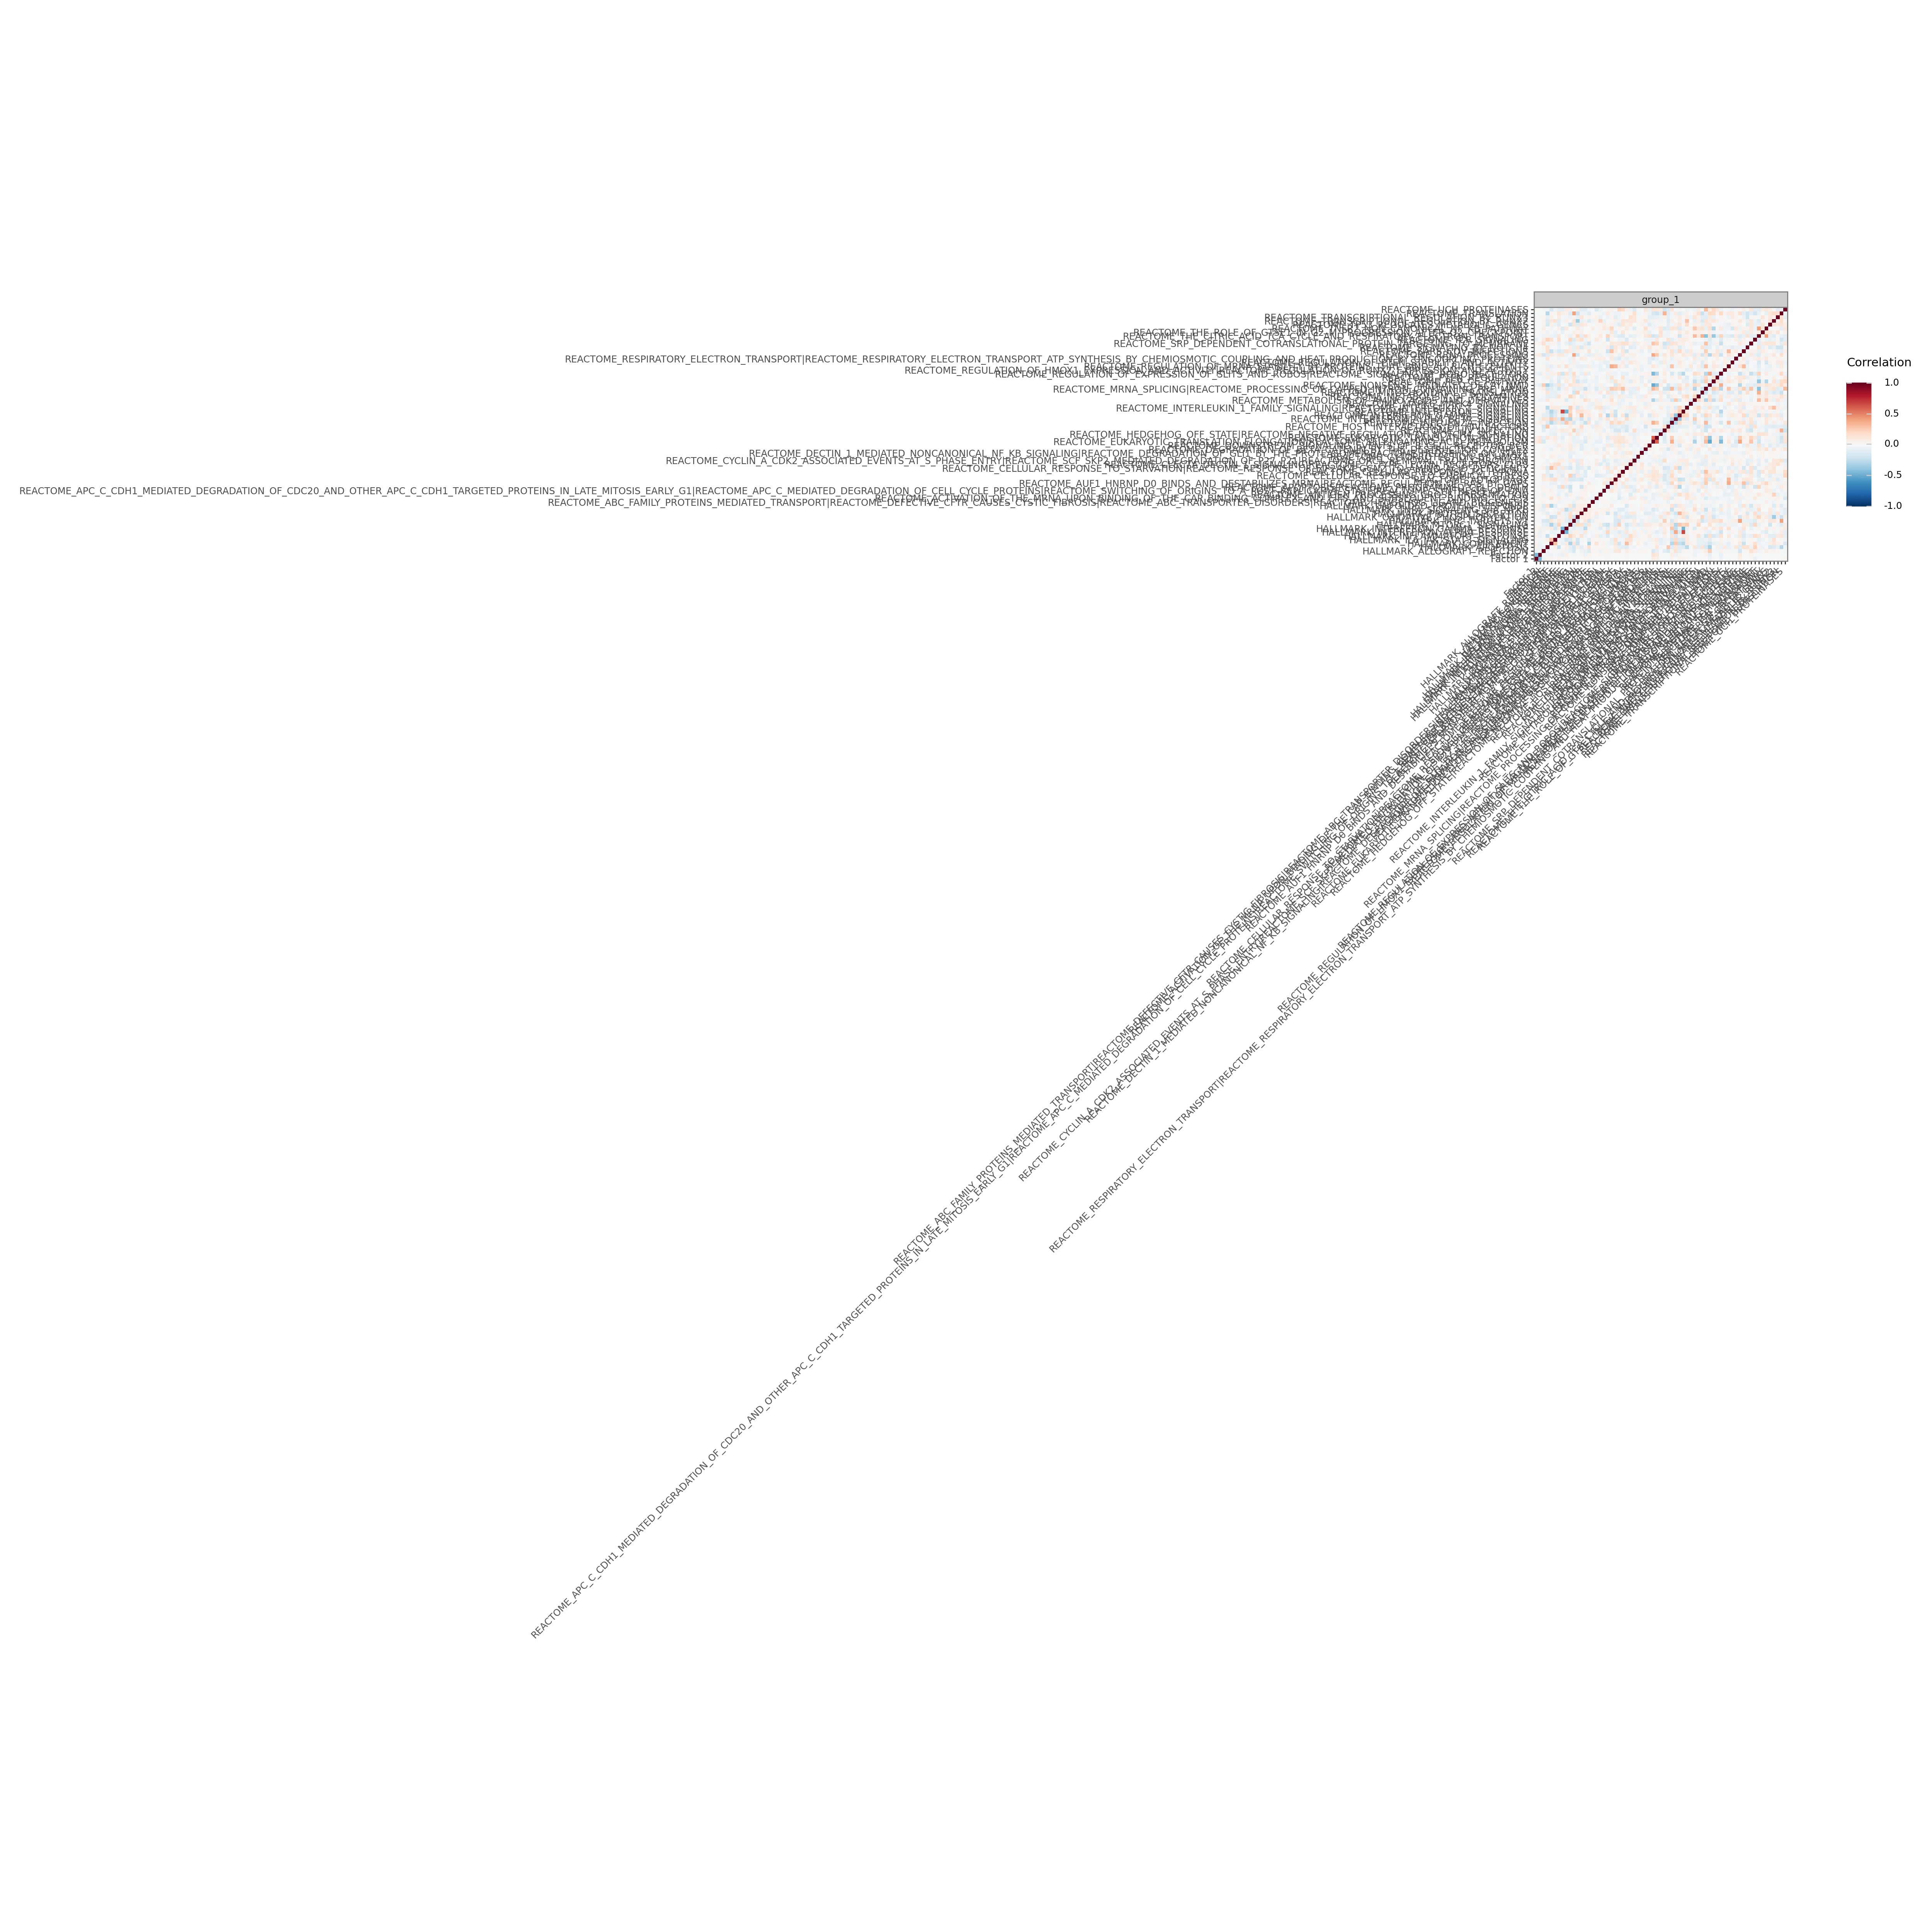

In [5]:
# Show correlation between factors
plot_factor_correlation(model, figsize=(25, 25))

# Pathway Analysis

### UMAP plots

In [6]:
adata_latent = model.get_factors("anndata")["group_1"].copy()
adata_latent.obs = adata.obs.copy()
obs_names = adata_latent.obs_names.to_numpy()
adata_latent = adata_latent[obs_names, :].copy()
adata_latent

AnnData object with n_obs × n_vars = 13576 × 67
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type'

In [7]:
sc.pp.neighbors(adata_latent, use_rep="X")
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)

In [ ]:
df_plot = pd.DataFrame(adata_latent.obsm["X_umap"])
df_plot["stim"] = adata_latent.obs["stim"].values
df_plot["cell_type"] = adata_latent.obs["cell_type"].values
df_plot.columns = ["UMAP1", "UMAP2", "stim", "cell_type"]
df_plot

In [ ]:
# Make scatterplot of UMAP embedding
p = (
    p9.ggplot(df_plot)
    + p9.aes(x="UMAP1", y="UMAP2", color="cell_type")
    + p9.geom_point(size=1.5, alpha=0.5)
    + p9.theme(legend_position="right")
    + p9.ggtitle("Cell Types")
    + p9.labs(color="Cell Type")
    + discrete_scale_color
)
p

In [ ]:
# Make scatterplot of UMAP embedding
p = (
    p9.ggplot(df_plot)
    + p9.aes(x="UMAP1", y="UMAP2", color="stim")
    + p9.geom_point(size=1.5, alpha=0.5)
    + p9.theme(legend_position="right")
    + p9.ggtitle("Conditions")
    + p9.labs(color="Conditions")
    + discrete_scale_color
)
p

In [11]:
df_plot = pd.DataFrame(
    {
        "x": adata_latent.obsm["X_umap"][:, 0],
        "y": adata_latent.obsm["X_umap"][:, 1],
        "cell type": adata_latent.obs["cell_type"],
        "condition": adata_latent.obs["condition"],
    }
)

(
    p9.ggplot(df_plot, p9.aes(x="x", y="y", color="condition"))
    + p9.geom_point(size=0.5, alpha=0.25)
    + p9.labs(title="Conditions", x="UMAP1", y="UMAP2")
    + p9.scale_color_manual(values=colors_disc)
    # Use colors_disc
)

(
    p9.ggplot(df_plot, p9.aes(x="x", y="y", color="cell type"))
    + p9.geom_point(size=0.33, alpha=0.5)
    + p9.labs(title="Cell Types", x="UMAP1", y="UMAP2")
    + p9.scale_color_manual(values=list(reversed(colors_disc)))
    + p9.guides(color=p9.guide_legend(override_aes={"size": 3, "alpha": 1}))
)

In [ ]:
sc.tl.rank_genes_groups(adata_latent, groupby="condition")

In [ ]:
dp = sc.pl.rank_genes_groups_dotplot(
    adata_latent,
    return_fig=True,
    groupby="cell_type",
    save="rank_genes_groups_dotplot.png",
    show=False,
    standard_scale="var",
    # values_to_plot="logfoldchanges",
    # cmap='bwr',
    # vmin=-4,
    # vmax=4,
    # min_logfoldchange=3,
    # colorbar_title='log fold change'
)
dp.add_totals().style(dot_edge_color="black", dot_edge_lw=0.5).show()

In [ ]:
dp = sc.pl.rank_genes_groups_dotplot(
    adata_latent, return_fig=True, standard_scale="var", groupby="condition"
)
dp.add_totals().style(dot_edge_color="black", dot_edge_lw=0.5).show()

In [ ]:
# Take all factors involving interferon and make 2D scatter plots between all of them
# factors = [vn for vn in adata_latent.var_names if "INTERFER" in vn]
factors = list(set([vn for vn in adata_latent.var_names if "INTERFER" in vn]))

df_plot = pd.DataFrame(model.get_factors("anndata")["group_1"].X)
df_plot.columns = model.get_factors("anndata")["group_1"].var_names
df_plot["condition"] = adata.obs["condition"].values

sns.pairplot(df_plot, hue="condition", vars=factors, plot_kws={"s": 3, "alpha": 0.25})

# Plot two pathways as scatterplot:
factors = ["REACTOME_INFLUENZA_INFECTION", "HALLMARK_INTERFERON_ALPHA_RESPONSE", "HALLMARK_INTERFERON_GAMMA_RESPONSE"]  # , "REACTOME_INTERFERON_SIGNALING"
df_plot = model.get_factors("anndata")["group_1"]
df_plot = pd.DataFrame(df_plot.X, columns=df_plot.var_names).assign(
    stim=adata.obs["stim"].reset_index(drop=True)
)

p = (
    p9.ggplot(df_plot)
    + p9.aes(x=factors[0], y=factors[1], color="stim")
    + p9.geom_point(size=1.5, alpha=0.25)
    + p9.theme(legend_position="right")
    + p9.ggtitle("Pathways")
    + p9.labs(color="Condition")
    + p9.xlab(factors[0].replace("_", " "))
    + p9.ylab(factors[1].replace("_", " "))
    + discrete_scale_color
)
p

features = df_plot[["Factor 1", "Factor 3"]].values
conditions = df_plot["condition"].values

nbrs = NearestNeighbors(n_neighbors=6, algorithm="auto").fit(features)
distances, indices = nbrs.kneighbors(features)

fractions = []
for i, neighbors in enumerate(indices):
    same_condition_count = sum(
        conditions[neighbors[1:]] == conditions[i]
    )  # Exclude the sample itself
    fractions.append(same_condition_count / 5)

np.average(fractions)

In [ ]:
# Take all factors involving interferon and make 2D scatter plots between all of them
# factors = [vn for vn in adata_latent.var_names if "INTERFER" in vn]
factors = list(
    set([vn for vn in adata_latent.var_names if "INTERFER" in vn])
    | set([x for x in dp.var_names if "INTERFER" in x or "Factor" in x])
)

df_plot = pd.DataFrame(model.get_factors("anndata")["group_1"].X)
df_plot.columns = model.get_factors("anndata")["group_1"].var_names
df_plot["condition"] = adata.obs["condition"].values

sns.pairplot(df_plot, hue="condition", vars=factors, plot_kws={"s": 3, "alpha": 0.25})

In [ ]:
dfx = model.get_weights("anndata")["view_1"]
dfx.X = np.abs(dfx.X)
# dfx[:, dfx.var_names.str.contains("ISG")].to_df().sort_values(
#     "ISG15", ascending=False
# ).head(10)

dfx.to_df().sort_values(
    "ISG15", ascending=False
).head(10).loc[:, ["ISG15", "IFIT1", "IFIT3", "IFITM1", "IFITM3", "IFITM2", "IFIT2"]]

In [19]:
ifn_factors = [vn for vn in adata_latent.var_names if "INTERFER" in vn]
factor_list = list(
    set(
        dfx[:, dfx.var_names.str.contains("ISG")]
        .to_df()
        .sort_values("ISG15", ascending=False)
        .head(10)["ISG15"]
        .index
    )
    | set(ifn_factors)
)

In [ ]:
plot_weights(
    model,
    n_features=20,
    views="view_1",
    # factors=factors,
    factors=[
        # "Factor 2",
        # "Factor 1",
        # "HALLMARK_INTERFERON_GAMMA_RESPONSE",
        # "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING",
        # "REACTOME_INTERFERON_GAMMA_SIGNALING",
        # "HALLMARK_INTERFERON_ALPHA_RESPONSE",
        # "REACTOME_INTERFERON_SIGNALING",
        "REACTOME_INFLUENZA_INFECTION",
        "HALLMARK_INTERFERON_ALPHA_RESPONSE",
        "HALLMARK_INTERFERON_GAMMA_RESPONSE"
    ],
    pointsize=2,
    figsize=(20, 7),
) + p9.facet_wrap("factor", nrow=1)

In [ ]:
* Significant stars
* Scatter plot 

def _prepare_weights_df(
    model: "PRISMO",
    n_features: int = 10,
    views = None,
    factors = None,
):
    weights = model.get_weights(ordered=False)
    annotations = model.get_annotations(ordered=False)
    if views is None:
        views = model.view_names
    elif isinstance(views, str):
        views = [views]
    if factors is None:
        factors = np.arange(model.n_factors)
    else:
        if not isinstance(factors, list):
            factors = [factors]
        if all(isinstance(factor, str) for factor in factors):
            factors = np.where(np.isin(model.factor_names, factors))[0] + 1
        factors = np.asarray(factors) - 1

    df = []
    have_annot = False

    for view in views:
        cdf = (
            weights[view]
            .iloc[factors, :]
            .reset_index(names="factor")
            .melt(id_vars="factor", var_name="feature", value_name="weight")
        )
        if view in annotations:
            cdf = pd.merge(
                cdf,
                annotations[view]
                .reset_index(names="factor")
                .melt(id_vars="factor", var_name="feature", value_name="annotation"),
                how="left",
                on=["factor", "feature"],
            )
            cdf["annotation"].fillna(False, inplace=True)
            have_annot = True
        else:
            cdf = cdf.assign(annotation=False)
        df.append(
            cdf.assign(
                view=view,
                weightabs=lambda x: x.weight.abs(),
                factor=lambda x: pd.Categorical(x.factor, categories=model.factor_names),
                inferred=lambda x: ~x.annotation & x.weightabs > 0,
            )
        )

    df = pd.concat(df, axis=0, ignore_index=False)
    return views, factors, df, have_annot


views, factors, df, have_annot = _prepare_weights_df(model, 20, "view_1", factor_list)
# for each factor in factor_list, filter df for this factor, sort all rows by weightabs, take the top 20 rows,
# remove all rows, where inferred is False.
for f in factor_list:
    x = list(df.loc[
        (df["factor"] == f)
    ]
    .sort_values("weightabs", ascending=False)
    .head(20)
    .loc[df["inferred"] == True]["feature"].values)
    print(f"{f}: {x}")

In [ ]:
plot_weights(
    model,
    n_features=20,
    views="view_1",
    factors=factor_list,
    pointsize=2,
    figsize=(20, 25),
) + p9.facet_wrap("factor", nrow=6)

In [23]:
df_plot = pd.DataFrame(adata_latent.X).assign(
    stim=adata_latent.obs["stim"].values, sample_id=range(len(adata_latent.obs))
)
df_plot.columns = adata_latent.var_names.tolist() + ["stim", "sample_id"]

In [ ]:
(
    p9.ggplot(
        df_plot,
        p9.aes(x="stim", y="REACTOME_INTERFERON_ALPHA_BETA_SIGNALING", color="stim"),
    )
    + p9.geom_boxplot()
    + p9.labs(x="Condition", y="REACTOME INTERFERON ALPHA BETA SIGNALING")
    + p9.theme(legend_title=p9.element_text(text="Condition"))
    + p9.theme(figure_size=(6, 4))
)